# Hackathon

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn

"Hello World"

'Hello World'

In [3]:
data = pd.read_excel('Hack_concentraducto_v01.xlsx', sheet_name='Data_Hackathon')
df1 = data.copy()
df1.head()

,tiempo,% Solido Bombeo concentrado_EB,Presión de Descarga_EB_1,Presión de Descarga_EB_2,Presion_Estación de Valvulas_EV1_1,Presion_Estación de Valvulas_EV1_2,Presión_SM-1,Presión_SM-2,Presión estación de valvulas 2_EV2_1,Presión estación de valvulas 2_EV2_2,Porcentaje de Solido Alimentación Espesador,Presión_EDT_1,Presión_EDT_2,Presión_EDT_3,Presión_SM-3,Presión_SM-4
0,2023-01-01 00:00:00,60.305771,-0.663051,1625.289917,3662.116943,3653.241699,16701.179688,3040.474121,3330.878174,3303.286377,59.756073,10653.394531,8614.203125,321.568634,2477.526611,1647.383789
1,2023-01-01 00:03:00,60.316761,-0.663393,1625.912354,3666.185059,3657.404053,16702.007812,3044.661621,3335.265137,3307.434814,59.675354,10658.351562,8619.733398,320.516357,2484.498535,1650.932861
2,2023-01-01 00:06:00,60.327747,-0.663736,1626.534790,3670.252930,3661.566406,16702.835938,3048.849121,3339.652100,3311.583252,59.709515,10658.579102,8621.905273,321.340149,2489.650879,1653.877686
3,2023-01-01 00:09:00,60.338734,-0.664078,1627.157349,3674.321045,3665.728760,16703.664062,3053.036621,3344.039062,3315.731689,59.712528,10663.964844,8622.951172,321.454895,2493.044678,1656.922974
4,2023-01-01 00:12:00,60.350990,-0.664420,1627.779785,3678.389160,3669.891357,16704.492188,3057.224121,3348.426025,3319.880127,59.747906,10667.239258,8625.802734,322.045898,2498.507568,1662.279785


In [4]:
df1.isnull().sum()

tiempo                                         0
% Solido  Bombeo concentrado_EB                0
Presión de Descarga_EB_1                       0
Presión de Descarga_EB_2                       0
Presion_Estación de Valvulas_EV1_1             0
Presion_Estación de Valvulas_EV1_2             0
Presión_SM-1                                   0
Presión_SM-2                                   0
Presión estación de valvulas 2_EV2_1           0
Presión estación de valvulas 2_EV2_2           0
Porcentaje de Solido Alimentación Espesador    0
Presión_EDT_1                                  0
Presión_EDT_2                                  0
Presión_EDT_3                                  0
Presión_SM-3                                   0
Presión_SM-4                                   0
dtype: int64

In [5]:
mean_concentrated = df1["% Solido  Bombeo concentrado_EB"].mean()
mean_concentrated

43.04818888272726

In [6]:
min_concentrated = df1["Presión de Descarga_EB_1"].min()
min_concentrated

-7.87132453918457

# Preprocesamiento
## Conversión de datos

In [65]:
df2 = data.copy()
conversion = 6.89476

df2['Presión de Descarga_EB_1'] = df2['Presión de Descarga_EB_1'].apply(lambda x: x * conversion)
df2['Presión de Descarga_EB_2'] = df2['Presión de Descarga_EB_2'].apply(lambda x: x * conversion)

In [54]:
from sklearn.preprocessing import StandardScaler

excluded_columns = ['tiempo']
normalize_columns = [col for col in df2.columns if col not in excluded_columns]

scaler = StandardScaler()

df_normalized = pd.DataFrame(scaler.fit_transform(df2[normalize_columns]), columns=normalize_columns)
df_normalized = pd.concat([df2[excluded_columns], df_normalized], axis=1)


In [66]:
df2.rename(columns=
           {'tiempo': 'T',
            '% Solido  Bombeo concentrado_EB': 'EB%', 
            'Presión de Descarga_EB_1': 'EB1',
            'Presión de Descarga_EB_2': 'EB2',
            'Presion_Estación de Valvulas_EV1_1': 'EV1_1',
            'Presión estación de valvulas 2_EV2_1': 'EV2_1',
            'Presion_Estación de Valvulas_EV1_2': 'EV1_2',
            'Presión estación de valvulas 2_EV2_2': 'EV2_2',
            'Presión_SM-1': 'SM1',
            'Presión_SM-2': 'SM2',
            'Presión_SM-3': 'SM3',
            'Presión_SM-4': 'SM4',
            'Porcentaje de Solido Alimentación Espesador': 'EDT%',
            'Presión_EDT_1': 'EDT1',
            'Presión_EDT_2': 'EDT2',
            'Presión_EDT_3': 'EDT3',
            }
           , inplace=True)

In [55]:
df_normalized.rename(columns=
           {'tiempo': 'T',
            '% Solido  Bombeo concentrado_EB': 'EB%', 
            'Presión de Descarga_EB_1': 'EB1',
            'Presión de Descarga_EB_2': 'EB2',
            'Presion_Estación de Valvulas_EV1_1': 'EV1_1',
            'Presión estación de valvulas 2_EV2_1': 'EV2_1',
            'Presion_Estación de Valvulas_EV1_2': 'EV1_2',
            'Presión estación de valvulas 2_EV2_2': 'EV2_2',
            'Presión_SM-1': 'SM1',
            'Presión_SM-2': 'SM2',
            'Presión_SM-3': 'SM3',
            'Presión_SM-4': 'SM4',
            'Porcentaje de Solido Alimentación Espesador': 'EDT%',
            'Presión_EDT_1': 'EDT1',
            'Presión_EDT_2': 'EDT2',
            'Presión_EDT_3': 'EDT3',
            }
           , inplace=True)

# Visualización de datos

array([[<Axes: xlabel='EB%', ylabel='EB%'>,
        <Axes: xlabel='EB1', ylabel='EB%'>,
        <Axes: xlabel='EB2', ylabel='EB%'>,
        <Axes: xlabel='EV1_1', ylabel='EB%'>,
        <Axes: xlabel='EV1_2', ylabel='EB%'>,
        <Axes: xlabel='SM1', ylabel='EB%'>,
        <Axes: xlabel='SM2', ylabel='EB%'>,
        <Axes: xlabel='EV2_1', ylabel='EB%'>,
        <Axes: xlabel='EV2_2', ylabel='EB%'>,
        <Axes: xlabel='EDT%', ylabel='EB%'>,
        <Axes: xlabel='EDT1', ylabel='EB%'>,
        <Axes: xlabel='EDT2', ylabel='EB%'>,
        <Axes: xlabel='EDT3', ylabel='EB%'>,
        <Axes: xlabel='SM3', ylabel='EB%'>,
        <Axes: xlabel='SM4', ylabel='EB%'>],
       [<Axes: xlabel='EB%', ylabel='EB1'>,
        <Axes: xlabel='EB1', ylabel='EB1'>,
        <Axes: xlabel='EB2', ylabel='EB1'>,
        <Axes: xlabel='EV1_1', ylabel='EB1'>,
        <Axes: xlabel='EV1_2', ylabel='EB1'>,
        <Axes: xlabel='SM1', ylabel='EB1'>,
        <Axes: xlabel='SM2', ylabel='EB1'>,
        <Axes: 

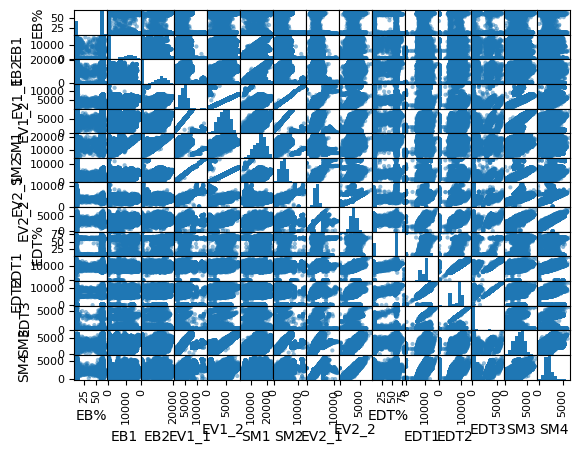

In [41]:
pd.plotting.scatter_matrix(df2)

array([[<Axes: xlabel='EB%', ylabel='EB%'>,
        <Axes: xlabel='EB1', ylabel='EB%'>,
        <Axes: xlabel='EB2', ylabel='EB%'>,
        <Axes: xlabel='EV1_1', ylabel='EB%'>,
        <Axes: xlabel='EV1_2', ylabel='EB%'>,
        <Axes: xlabel='SM1', ylabel='EB%'>,
        <Axes: xlabel='SM2', ylabel='EB%'>,
        <Axes: xlabel='EV2_1', ylabel='EB%'>,
        <Axes: xlabel='EV2_2', ylabel='EB%'>,
        <Axes: xlabel='EDT%', ylabel='EB%'>,
        <Axes: xlabel='EDT1', ylabel='EB%'>,
        <Axes: xlabel='EDT2', ylabel='EB%'>,
        <Axes: xlabel='EDT3', ylabel='EB%'>,
        <Axes: xlabel='SM3', ylabel='EB%'>,
        <Axes: xlabel='SM4', ylabel='EB%'>],
       [<Axes: xlabel='EB%', ylabel='EB1'>,
        <Axes: xlabel='EB1', ylabel='EB1'>,
        <Axes: xlabel='EB2', ylabel='EB1'>,
        <Axes: xlabel='EV1_1', ylabel='EB1'>,
        <Axes: xlabel='EV1_2', ylabel='EB1'>,
        <Axes: xlabel='SM1', ylabel='EB1'>,
        <Axes: xlabel='SM2', ylabel='EB1'>,
        <Axes: 

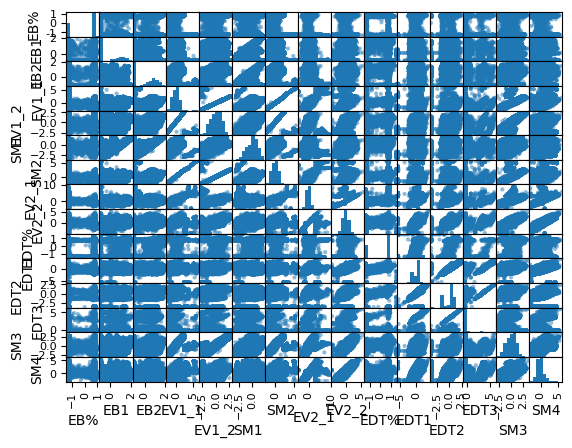

In [56]:
pd.plotting.scatter_matrix(df_normalized)

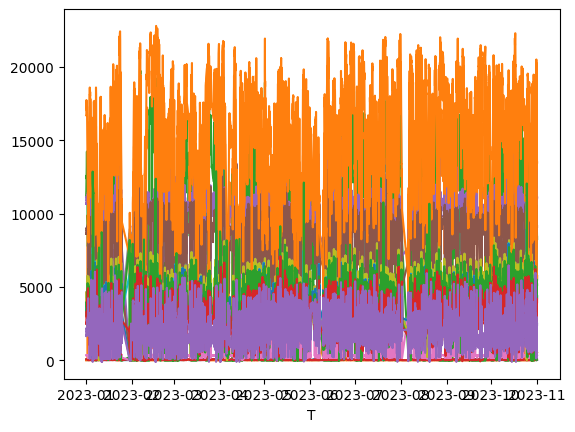

In [21]:
feats = df2.columns.difference(['T'])
for feat in df2.columns.difference(['T']):
 plt.plot(df2['T'], df2[feat])
plt.xlabel('T')
plt.show()

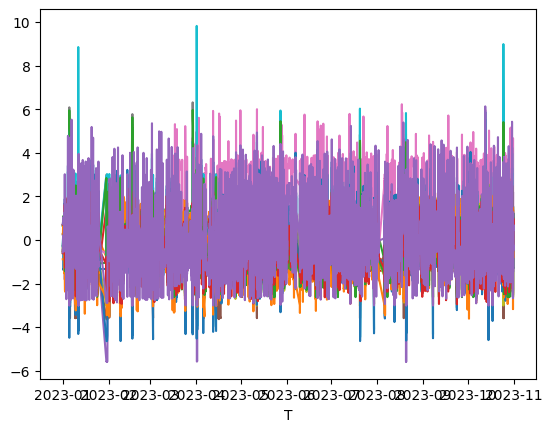

In [57]:
for feat in feats:
 plt.plot(df_normalized['T'], df_normalized[feat])
plt.xlabel('T')
plt.show()

### Correlación entre SM2 y EV2
Analizando el conjunto de datos, se encontró que, en casos donde la presión de SM2 cambia entre dos tuplas de manera drástica, el cambio se propaga de manera instantánea a la presión de EV2. Esto se puede observar en el siguiente gráfico:

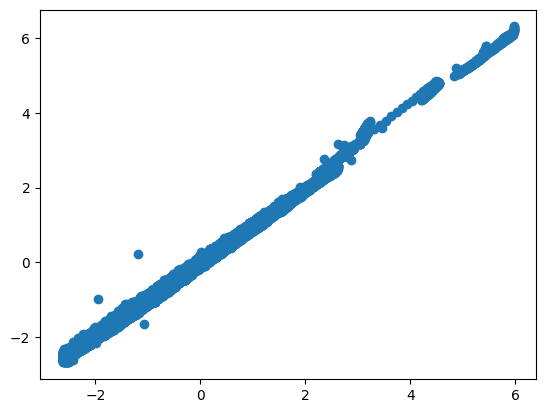

In [67]:
plt.scatter(df_normalized['SM2'], df_normalized['EV1_1'], xlabel='SM2', ylabel='EV1_1')

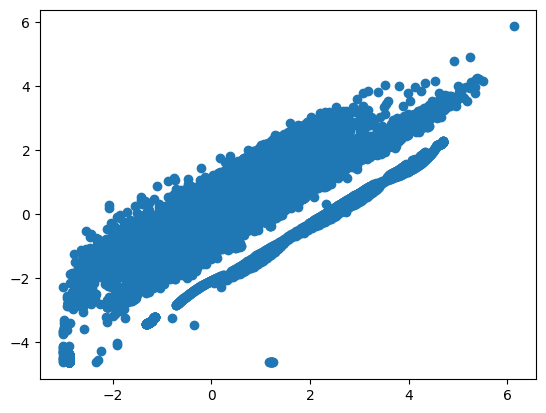

In [69]:
plt.scatter(df_normalized['SM4'], df_normalized['EV2_2'])

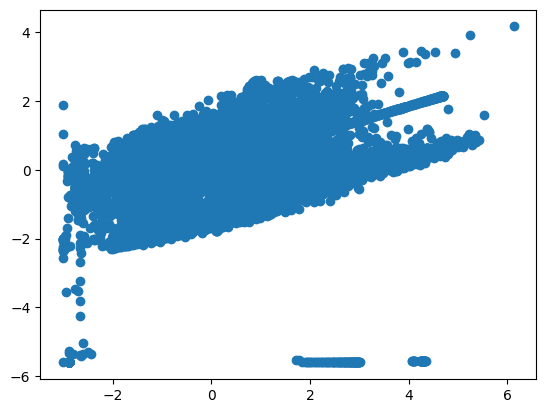

In [70]:
plt.scatter(df_normalized['SM4'], df_normalized['EDT1'])

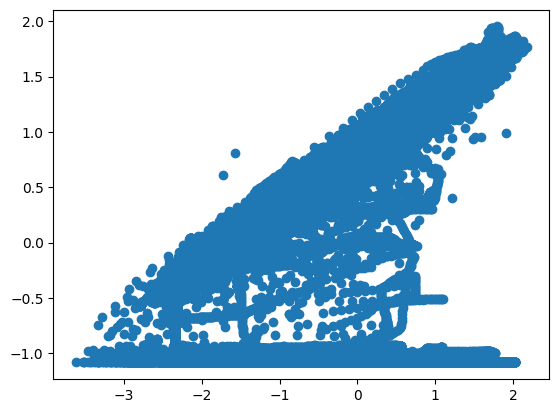

In [71]:
plt.scatter(df_normalized['SM1'], df_normalized['EB2'])


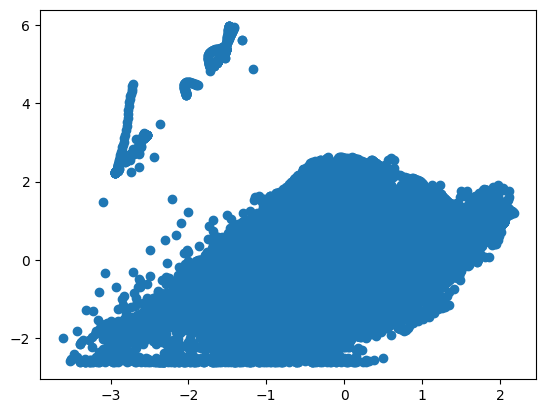

In [77]:
plt.scatter(df_normalized['SM1'], df_normalized['SM2'])

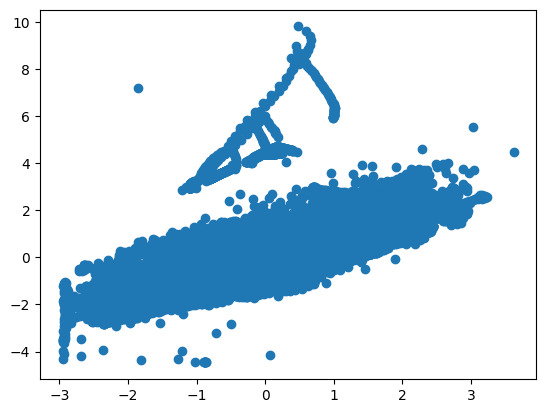

In [78]:
plt.scatter(df_normalized['SM3'], df_normalized['EV2_1'])

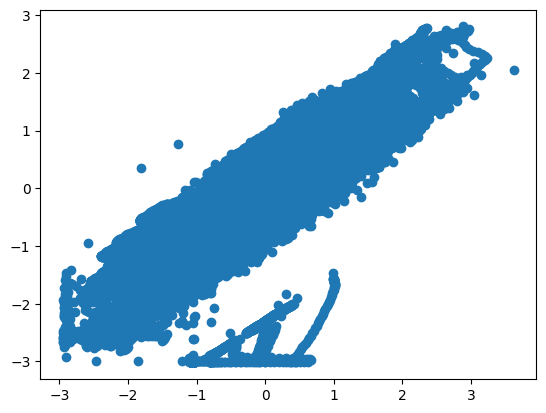

In [76]:
plt.scatter(df_normalized['SM3'], df_normalized['EV1_2'])

# Modelo Lineal

In [38]:
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

## Predicción SM1

In [58]:
X_1 = df_normalized[df_normalized.columns.difference(['T', 'SM1'])]
y_1 = df_normalized['SM1']
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, random_state=42, test_size=0.3)

### Regresión Linear

In [59]:
sm1 = LinearRegression()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.7646956779553075, MAE = 0.35174669468610437


Observaciones:
Mayor puntuación, con un 30% de datos asignados para validación, con todos los datos de presión en [kPa]

### Regresión Lasso

In [60]:
sm1 = LassoCV(max_iter=5000)
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.7640294850536453, MAE = 0.35235030515516674


En primer intento, se tuvo menor puntaje y problemas de convergencia.
Se aumenta número de iteraciones y se obtiene mayor demora, manteniendo puntaje.

### Elastic Net

In [61]:
sm1 = ElasticNetCV()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.7607217032875335, MAE = 0.3538371140765066


C:\Program Files\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.927e+03, tolerance: 9.228e+00
  model = cd_fast.enet_coordinate_descent(


### SGD

In [62]:
sm1 = SGDRegressor()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.7512572926749781, MAE = 0.3568123014659091


### Random Forest

In [63]:
sm1 = RandomForestRegressor()
sm1.fit(X_train, y_train)
y_pred = sm1.predict(X_test)
r2_1 = r2_score(y_test, y_pred)
mae_1 = mean_absolute_error(y_test, y_pred)
print(f'SM1: R2 = {r2_1}, MAE = {mae_1}')

SM1: R2 = 0.9920427582669582, MAE = 0.033948200180369155


Observaciones:
Entrenamiento lento, fuera de plazo máximo. Descartado.